# Lending Club Default Rate Analysis

## KS Test for Loan Issuance Decision Making

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pylab as pl
%matplotlib inline

### Columns Interested
**loan_status** -- Current status of the loan<br/>

loan_amnt -- The listed amount of the loan applied for by the borrower. If at some point in time, the credit        department reduces the loan amount, then it will be reflected in this value.<br/>
int_rate -- interest rate of the loan <br/>
sub_grade -- LC assigned sub loan grade -- **dummie**  (grade -- LC assigned loan grade<br/>-- **dummie**)<br/> 

purpose -- A category provided by the borrower for the loan request. -- **dummie**<br/> 

annual_inc -- The self-reported annual income provided by the borrower during registration.<br/>
emp_length -- Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. -- **dummie**<br/> 

fico_range_low<br/>
fico_range_high

home_ownership -- The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER -- **dummie**<br/>
tot_cur_bal -- Total current balance of all accounts							
num_actv_bc_tl -- number of active bank accounts   (*avg_cur_bal -- average current balance of all accounts *)<br/>

mort_acc -- number of mortgage accounts<br/>

num_actv_rev_tl	-- Number of currently active revolving trades<br/>
dti	-- A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.																								
pub_rec_bankruptcies - Number of public record bankruptcies<br/>


## 2015 Lending Club Data
### 1. Unapproved Loans

In [1]:
# !wget https://www.dropbox.com/s/0o28v7qkjzdprb8/RejectStats2015.csv.zip?dl=0/RejectStats2015.csv.zip

In [3]:
df_unapp_2015 = pd.read_csv('Data/RejectStats2015.csv.zip', compression='zip',header=1,low_memory=False)

In [18]:
df_unapp_15 = df_unapp_2015.dropna()

In [19]:
df_unapp_15.head(10)

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,30000.0,2015-01-01,debt_consolidation,681.0,35.65%,958xx,CA,< 1 year,0
1,5000.0,2015-01-01,debt_consolidation,648.0,10.62%,945xx,CA,< 1 year,0
2,10000.0,2015-01-01,Debt consolidation,721.0,10.02%,750xx,TX,7 years,0
3,10000.0,2015-01-01,major_purchase,659.0,19.05%,853xx,AZ,< 1 year,0
4,5000.0,2015-01-01,debt_consolidation,501.0,10.73%,475xx,IN,< 1 year,0
5,6000.0,2015-01-01,debt_consolidation,551.0,8.71%,019xx,MA,< 1 year,0
6,10000.0,2015-01-01,debt_consolidation,633.0,12.57%,840xx,UT,< 1 year,0
7,15000.0,2015-01-01,debt_consolidation,658.0,43.52%,913xx,CA,< 1 year,0
8,20000.0,2015-01-01,moving,573.0,18.53%,770xx,TX,< 1 year,0
9,25000.0,2015-01-01,house,640.0,5.06%,606xx,IL,< 1 year,0


In [20]:
len(df_unapp_15)

510451

In [125]:
## pick study columns in common in both approved and unapproved datasets
df_unapp_test = df_unapp_15[['Amount Requested', 'Risk_Score', 'Debt-To-Income Ratio']]

## remove percentage sign and convert to numeric
df_unapp_test.loc[:, 'Debt-To-Income Ratio'] = df_unapp_test.loc[:, 'Debt-To-Income Ratio'].apply(lambda r: float(r[:-1]))


### using "Outlier Boundry" found in data preprocessing for loan amount to exclude the potential outliers
outlier_bound = 33600.0

df_unapp_test = df_unapp_test[df_unapp_test['Amount Requested'] <= outlier_bound]  # approved loans

In [126]:
len(df_unapp_15)

510451

In [127]:
df_unapp_test.tail(3)

,Amount Requested,Risk_Score,Debt-To-Income Ratio
2859361,1000.0,627.0,25.45
2859366,1000.0,530.0,11.66
2859377,2000.0,652.0,0.60


## 2. Approved Loans

In [119]:
df_app_2015 = pd.read_csv('Data/approved_loan_2015_clean.csv', low_memory=False).loc[:, 'loan_amnt':]

#df_app_2015 = pd.read_csv('Data/LoanStats3d_securev1.csv.zip', compression='zip',header=1, low_memory=False)

In [121]:
df_app_2015.head(3)

,loan_amnt,annual_inc,fico_range_low,fico_range_high,num_actv_bc_tl,tot_cur_bal,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,dti,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,int_rate
0,16000.0,62000.0,720.0,724.0,4.0,227708.0,3.0,5.0,0.0,28.92,...,0,0,0,0,0,0,0,0,0,8.49
1,8000.0,45000.0,670.0,674.0,3.0,148154.0,2.0,11.0,0.0,21.23,...,0,0,0,0,0,0,0,0,0,10.78
2,10000.0,41600.0,695.0,699.0,2.0,168304.0,2.0,5.0,0.0,15.78,...,0,0,0,0,0,0,0,0,0,10.78


In [212]:
## Pick approved and fully paid loans
df_app_2015_paid = df_app_2015[df_app_2015['Target']==1]

## Pick apprived and default loans
df_app_2015_default= df_app_2015[df_app_2015['Target']==0]

In [213]:
## pick columns and drop nan
df_app_15 = df_app_2015[['loan_amnt', 'fico_range_low', 'dti']].dropna()

df_app_15_paid = df_app_2015_paid[['loan_amnt', 'fico_range_low', 'dti']].dropna()
df_app_15_default = df_app_2015_default[['loan_amnt', 'fico_range_low', 'dti']].dropna()

In [214]:
df_app_15.shape

(419213, 3)

In [215]:
df_app_15_paid.shape

(94440, 3)

In [216]:
df_app_15_default.shape

(42212, 3)

In [128]:
df_app_15.head(3)

,loan_amnt,fico_range_low,dti
0,16000.0,720.0,28.92
1,8000.0,670.0,21.23
2,10000.0,695.0,15.78


In [217]:
### using pre-set "Outlier Boundry" for loan amount to exclude the potential outliers

outlier_bound = 33600.0

df_app_test = df_app_15[df_app_15['loan_amnt'] <= outlier_bound]  # approved loans

df_app_paid_test = df_app_15_paid[df_app_15_paid['loan_amnt'] <= outlier_bound]  # approved and fully paid loans
df_app_default_test = df_app_15_default[df_app_15_default['loan_amnt'] <= outlier_bound]  # approved loans and default loans

In [218]:
len(df_app_test)

398912

## 3. KS Test for Numberic Features

### Loan Amount, Credit Score, Debt-To-Income Ratio

In [53]:
## All Data -- might be too large to run
## KS two sample test to compare unapproved and approved loans
# stats.ks_2samp(df_unapp_test['Amount Requested'], df_app_tes['loan_amnt'])

## KS two sample test to compare unapproved and approved loans
#stats.ks_2samp(df_unapp_test['Risk_Score'], df_app_test['fico_range_low'])

In [210]:
### TEST with Samples using differen random states
random_states = np.random.randint(1, 1000, 10)

for rs in random_states:
    df_unapp_test_s = df_unapp_test.sample(n=10000, random_state=rs)
    df_app_test_s = df_app_test.sample(n=10000, random_state=rs)
    
    ## KS two sample test to compare unapproved and approved loan samples
    print '\nrandom_state = {}'.format(rs)
    print 'KS result on loan amounts:\n', stats.ks_2samp(sorted(df_unapp_test_s['Amount Requested']), \
                                                         sorted(df_app_test_s['loan_amnt']))
    
    ## KS two sample test to compare unapproved and approved loans -- samples
    print 'KS result on credit scores:\n', stats.ks_2samp(sorted(df_unapp_test_s['Risk_Score']), \
                                                          sorted(df_app_test_s['fico_range_low']))
    
    
    ## KS two sample test to compare unapproved and approved loans -- samples
    print 'KS result on dti:\n', stats.ks_2samp(sorted(df_unapp_test_s['Debt-To-Income Ratio']), \
                                                          sorted(df_app_test_s['dti']))


random_state = 772
KS result on loan amounts:
Ks_2sampResult(statistic=0.2409, pvalue=2.5146344003229898e-253)
KS result on credit scores:
Ks_2sampResult(statistic=0.64900000000000002, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.23799999999999999, pvalue=2.8363180782656296e-247)

random_state = 55
KS result on loan amounts:
Ks_2sampResult(statistic=0.23049999999999998, pvalue=5.8248944626217823e-232)
KS result on credit scores:
Ks_2sampResult(statistic=0.64659999999999995, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.24260000000000004, pvalue=6.584273096333656e-257)

random_state = 246
KS result on loan amounts:
Ks_2sampResult(statistic=0.23619999999999997, pvalue=1.4875611476517412e-243)
KS result on credit scores:
Ks_2sampResult(statistic=0.64739999999999998, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.23419999999999996, pvalue=1.872306621618541e-239)

random_state = 205
KS result on loan amounts:
Ks_2sampResult(statistic=0.23320000000000002, pv

### Credit Score: Top 25% of Uapproved v.s. Bottom 25% of Approved loans 

In [132]:
## Top25% scores lower bound -- whole clean data
df_unapp_test.describe().Risk_Score

count    455567.000000
mean        634.360955
std          64.139430
min         300.000000
25%         595.000000
50%         639.000000
75%         675.000000
max         990.000000
Name: Risk_Score, dtype: float64

In [133]:
## Top25% scores lower bound -- sample data
df_unapp_test_s.describe().Risk_Score[6]

675.0

In [134]:
## Bottom 25% scores upper bound -- whole clean data
df_app_test.describe().fico_range_low

count    398912.000000
mean        693.235601
std          30.073075
min         660.000000
25%         670.000000
50%         685.000000
75%         710.000000
max         845.000000
Name: fico_range_low, dtype: float64

In [135]:
## Bottom 25% scores upper bound -- sample data
df_app_test_s.describe().fico_range_low[4]

670.0

In [208]:
### TEST with Samples using differen random states
random_states = np.random.randint(1, 100, 5)

for rs in random_states:
    
    # Sampling
    df_unapp_test_s = df_unapp_test.sample(n=10000, random_state=rs)
    df_app_test_s = df_app_test.sample(n=10000, random_state=rs)
    
    ### Select applications based on top 25% and bottom 25% credit scores boundries
    top25_bound_unapp = df_unapp_test_s.describe().Risk_Score[6]  ## Top25% scores lower bound -- sample data
    bot25_bound_app = df_app_test_s.describe().fico_range_low[4] ## Bottom 25% scores upper bound -- sample data

    df_unapp_top25= df_unapp_test_s[df_unapp_test_s['Risk_Score'] >= top25_bound_unapp]  # unapproved loans
    df_app_bot25 = df_app_test_s[df_app_test_s['fico_range_low'] <= bot25_bound_app]  # approved loans

    
    ## KS two sample test to compare unapproved and approved loan samples
    print '\nrandom_state = {}'.format(rs)
    print 'KS result on loan amounts:\n', stats.ks_2samp(sorted(df_unapp_top25['Amount Requested']), \
                                                         sorted(df_app_bot25['loan_amnt']))
    
    ## KS two sample test to compare unapproved and approved loans -- samples
    print 'KS result on credit scores:\n', stats.ks_2samp(sorted(df_unapp_top25['Risk_Score']), \
                                                          sorted(df_app_bot25['fico_range_low']))
    
    
    ## KS two sample test to compare unapproved and approved loans -- samples
    print 'KS result on dti:\n', stats.ks_2samp(sorted(df_unapp_top25['Debt-To-Income Ratio']), \
                                                sorted(df_app_bot25['dti']))


random_state = 86
KS result on loan amounts:
Ks_2sampResult(statistic=0.096502468478963266, pvalue=1.4340907614250704e-11)
KS result on credit scores:
Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.32824693546396921, pvalue=2.3031926601133455e-129)

random_state = 31
KS result on loan amounts:
Ks_2sampResult(statistic=0.12311723614101355, pvalue=2.3059134465141237e-18)
KS result on credit scores:
Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.31725349756219379, pvalue=1.5471652752950035e-119)

random_state = 1
KS result on loan amounts:
Ks_2sampResult(statistic=0.1260232618901409, pvalue=5.0269520742154843e-19)
KS result on credit scores:
Ks_2sampResult(statistic=1.0, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.32413541755076158, pvalue=1.8100939077936015e-123)

random_state = 1
KS result on loan amounts:
Ks_2sampResult(statistic=0.1260232618901409, pvalue=5.0269520742154843e-19)
KS result on 

### Unapproved VS Fully Paid Loans

In [220]:
## KS two sample test to compare unapproved and fully paid loans

print '\nKS result on loan amounts:\n', stats.ks_2samp(sorted(df_unapp_test.sample(n=len(df_app_paid_test))['Amount Requested']), \
                                                     sorted(df_app_paid_test['loan_amnt']))
    

print 'KS result on credit scores:\n', stats.ks_2samp(sorted(df_unapp_test.sample(n=len(df_app_paid_test))['Risk_Score']), \
                                                      sorted(df_app_paid_test['fico_range_low']))
    
    
print 'KS result on dti:\n', stats.ks_2samp(sorted(df_unapp_test.sample(n=len(df_app_paid_test))['Debt-To-Income Ratio']), \
                                            sorted(df_app_paid_test['dti']))
                                            


KS result on loan amounts:
Ks_2sampResult(statistic=0.21697798161052612, pvalue=0.0)
KS result on credit scores:
Ks_2sampResult(statistic=0.6535387492486141, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.24806865997283878, pvalue=0.0)


### Unapproved VS Default Loans

In [221]:
## KS two sample test to compare unapproved and default loans

print '\nKS result on loan amounts:\n', stats.ks_2samp(sorted(df_unapp_test.sample(n=len(df_app_default_test))['Amount Requested']), \
                                                     sorted(df_app_default_test['loan_amnt']))
    

print 'KS result on credit scores:\n', stats.ks_2samp(sorted(df_unapp_test.sample(n=len(df_app_default_test))['Risk_Score']), \
                                                      sorted(df_app_default_test['fico_range_low']))
    
    
print 'KS result on dti:\n', stats.ks_2samp(sorted(df_unapp_test.sample(n=len(df_app_default_test))['Debt-To-Income Ratio']), \
                                            sorted(df_app_default_test['dti']))
                                            


KS result on loan amounts:
Ks_2sampResult(statistic=0.2590856684545591, pvalue=0.0)
KS result on credit scores:
Ks_2sampResult(statistic=0.6519123765602286, pvalue=0.0)
KS result on dti:
Ks_2sampResult(statistic=0.22191588550804553, pvalue=0.0)


## 3. Visual Comparison between Unapproved and Approved Loans 
** Based on Credit Score: Top 25% of Uapproved v.s. Bottom 25% of Approved loans**

In [236]:
# make plots for distributions of loan features
def plot_feature_dist(df_unapp, col_unapp, df_app, col_app, ylabel=None, heading=None):
    
    # Sampling
    df_unapp_test_s = df_unapp.sample(n=10000, random_state=22)
    df_app_test_s = df_app.sample(n=10000, random_state=22)
    
    ### Select applications based on top 25% and bottom 25% credit scores boundries
    top25_bound_unapp = df_unapp_test_s.describe().Risk_Score[6]  ## Top25% scores lower bound -- sample data
    bot25_bound_app = df_app_test_s.describe().fico_range_low[4] ## Bottom 25% scores upper bound -- sample data

    df_unapp_top25= df_unapp_test_s[df_unapp_test_s['Risk_Score'] >= top25_bound_unapp]  # unapproved loans
    df_app_bot25 = df_app_test_s[df_app_test_s['fico_range_low'] <= bot25_bound_app]  # approved loans
    
    ### Plot ###
    fig = pl.figure(figsize=(8,6))
    
    pl.plot(range(1, len(df_unapp_top25)+1), sorted(df_unapp_top25[col_unapp]), 'r.', alpha=0.6, label='unapproved loans')    
    pl.plot(range(1,len(df_app_bot25)+1), sorted(df_app_bot25[col_app]), 'g.', alpha=0.6, label='approved loans')      
    #upper = max(df_unapp_top25[col_unapp].max(), df_app_bot25[col_app].max())  
    
    num = min(len(df_unapp_top25), len(df_app_bot25))  
    pl.xlim(1, num+1)
    pl.xticks(np.arange(1, num+1, 1000), np.arange(1, num+1, 1000))
    pl.xlabel('Loan Applications', size=15)
    pl.ylabel(ylabel, size=15)
    pl.title(heading, size=18)
    pl.legend(loc='best', fontsize='xx-large')
    
    # footnote
    fig.text(0.99, 0.01, 'data source: Lending Club', ha='right', 
        va='bottom', fontsize=10, color='#999999')
    
    pl.tight_layout()

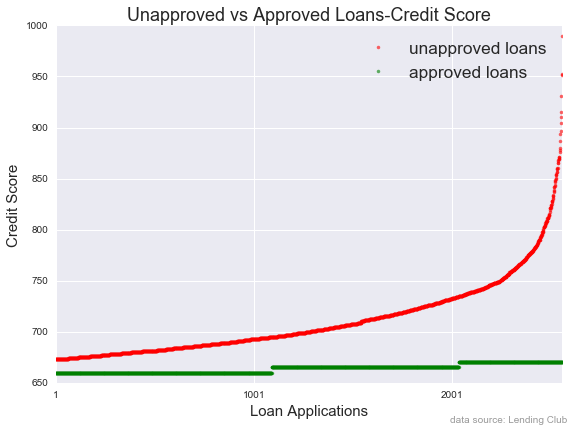

In [237]:
## Credit Score
plot_feature_dist(df_unapp_test, 'Risk_Score', df_app_test, 'fico_range_low',\
                  ylabel='Credit Score', heading='Unapproved vs Approved Loans-Credit Score')

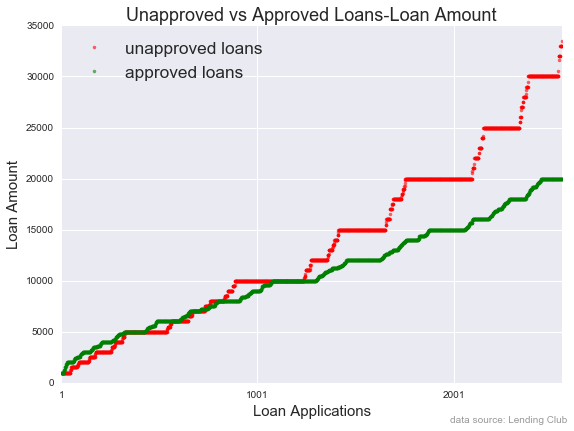

In [238]:
## Loan Amounts
plot_feature_dist(df_unapp_test, 'Amount Requested', df_app_test, 'loan_amnt',\
                  ylabel='Loan Amount', heading='Unapproved vs Approved Loans-Loan Amount')

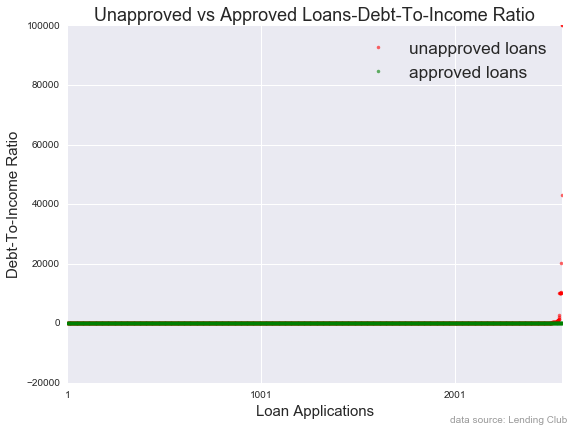

In [239]:
## Debt-To-Income Ratio
plot_feature_dist(df_unapp_test, 'Debt-To-Income Ratio', df_app_test, 'dti',\
                  ylabel='Debt-To-Income Ratio', heading='Unapproved vs Approved Loans-Debt-To-Income Ratio')

### Upproved vs Approved & Fully Paid Loans
25% top and 25% bottom

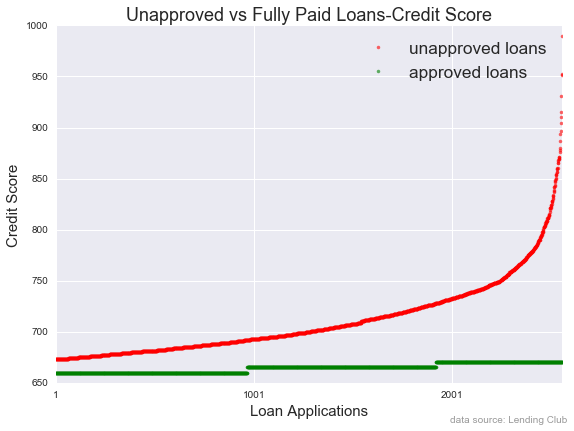

In [240]:
## Credit Score
plot_feature_dist(df_unapp_test, 'Risk_Score', df_app_paid_test, 'fico_range_low',\
                  ylabel='Credit Score', heading='Unapproved vs Fully Paid Loans-Credit Score')

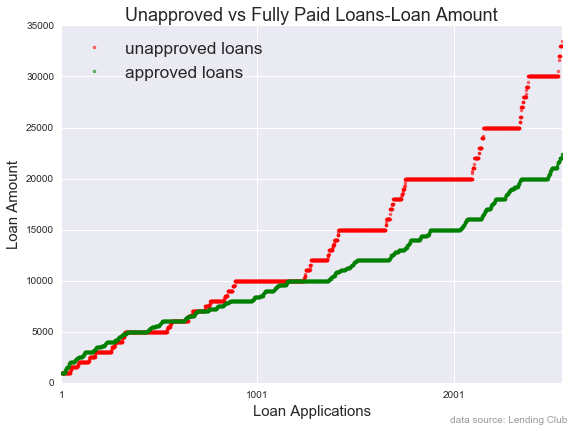

In [241]:
## Loan Amounts
plot_feature_dist(df_unapp_test, 'Amount Requested', df_app_paid_test, 'loan_amnt',\
                  ylabel='Loan Amount', heading='Unapproved vs Fully Paid Loans-Loan Amount')

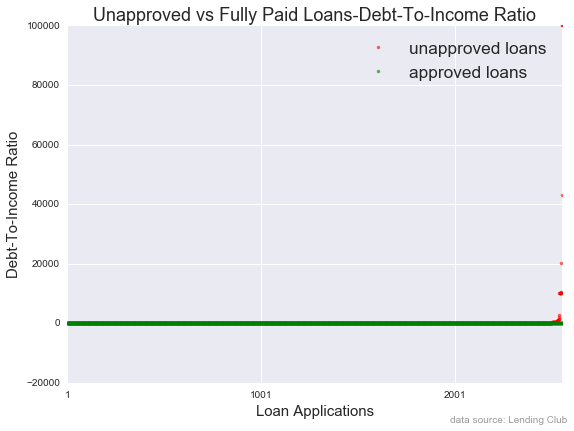

In [242]:
## Debt-To-Income Ratio
plot_feature_dist(df_unapp_test, 'Debt-To-Income Ratio', df_app_paid_test, 'dti',\
                  ylabel='Debt-To-Income Ratio', heading='Unapproved vs Fully Paid Loans-Debt-To-Income Ratio')

### Upproved vs Approved & Default Loans
25% top and 25% bottom

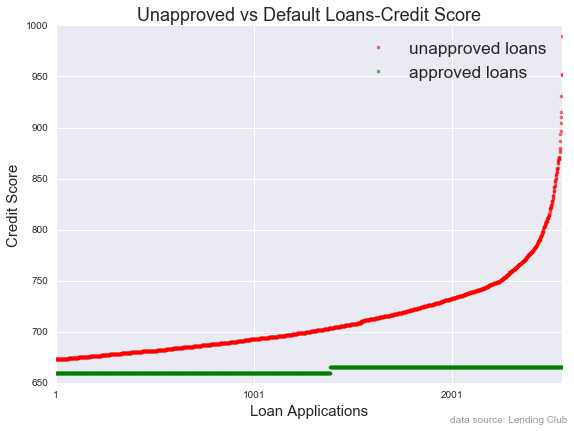

In [243]:
## Credit Score
plot_feature_dist(df_unapp_test, 'Risk_Score', df_app_default_test, 'fico_range_low',\
                  ylabel='Credit Score', heading='Unapproved vs Default Loans-Credit Score')

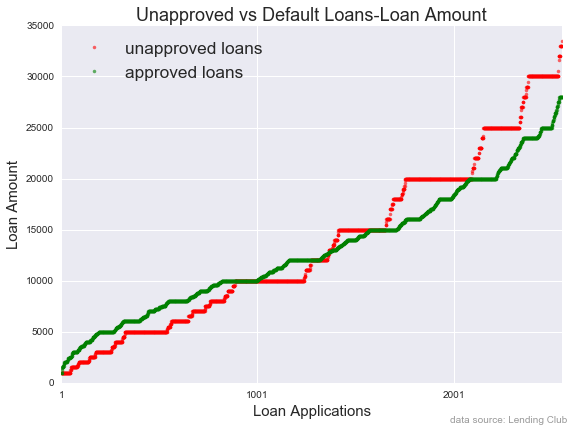

In [244]:
## Loan Amounts
plot_feature_dist(df_unapp_test, 'Amount Requested', df_app_default_test, 'loan_amnt',\
                  ylabel='Loan Amount', heading='Unapproved vs Default Loans-Loan Amount')

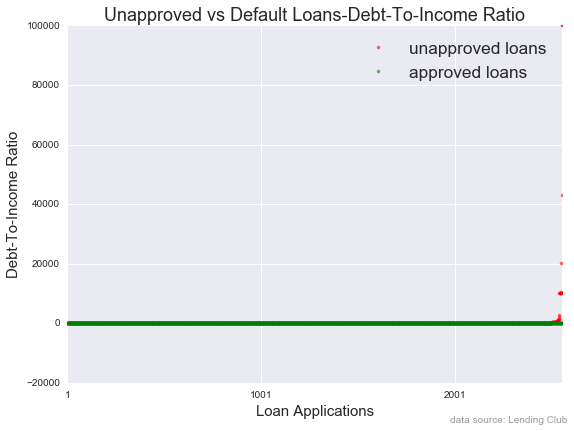

In [245]:
## Debt-To-Income Ratio
plot_feature_dist(df_unapp_test, 'Debt-To-Income Ratio', df_app_default_test, 'dti',\
                  ylabel='Debt-To-Income Ratio', heading='Unapproved vs Default Loans-Debt-To-Income Ratio')